# Pneumonia Detection

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pathlib as Path
import os

In [45]:
# verifica se è presente una GPU per l'esecuzione.
print(f"Is GPU available? {torch.cuda.is_available()}")

Is GPU available? True


In [46]:
import shutil
import kagglehub

dataset_url = "paultimothymooney/chest-xray-pneumonia"
DATA_DIR = "chest_xray/chest_xray"

def load_data():
    """
    Load original pneumonia images data from the Kaggle's dataset. 
    """
    # if it finds the data does nothing otherwise it installs it --> cannot pass the dataset to Github for dimension limitations
    if os.path.exists(DATA_DIR):
        print(f"Data found in {DATA_DIR}")
    else:
        # Download latest version --> kagglehub stores the dataset in a sort of cached memory so you need to copy it in local
        path = kagglehub.dataset_download(dataset_url)
        
        shutil.copytree(path, ".", dirs_exist_ok=True)

        print("Path to dataset files:", path)
        
load_data()

Data found in chest_xray/chest_xray


In [47]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

RESIZE_IMG = (128, 128) # resize img from (224,224) -> (128, 128)
datasets_names = ["train", "val", "test"]

# we create a set of transformations -> operations that will be applied to each img of the dataset for preprocessing
data_transforms = {
    x: transforms.Compose([
        transforms.Resize(RESIZE_IMG), # resizes the image to the desired dimension
        transforms.Grayscale(num_output_channels=3), # the paper uses three channels for these images
        transforms.ToTensor(), # convert all the values from range [0, 255] -> [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], # Standard ImageNet normalization
                             [0.229, 0.224, 0.225]) # a quanto pare sono valori standardizzati usati per trainare modelli (si potrebbe pensare di rimuoverli)
    ]) for x in datasets_names
}

# build a dictionary with three keys for each dataset we have (train, val, test)
# it also applies the transformations defined before
image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in datasets_names
}

class_names = image_datasets["train"].classes
print(class_names) # print the two classes we are labeling

['NORMAL', 'PNEUMONIA']


In [48]:
# data on the sizes of the single datasets 
dataset_sizes = {x: len(image_datasets[x]) for x in datasets_names}

# printing the number of elements for each dataset.
for x, y in dataset_sizes.items():
    print(f"Dataset {x} has {y} elements.")

Dataset train has 5216 elements.
Dataset val has 16 elements.
Dataset test has 624 elements.


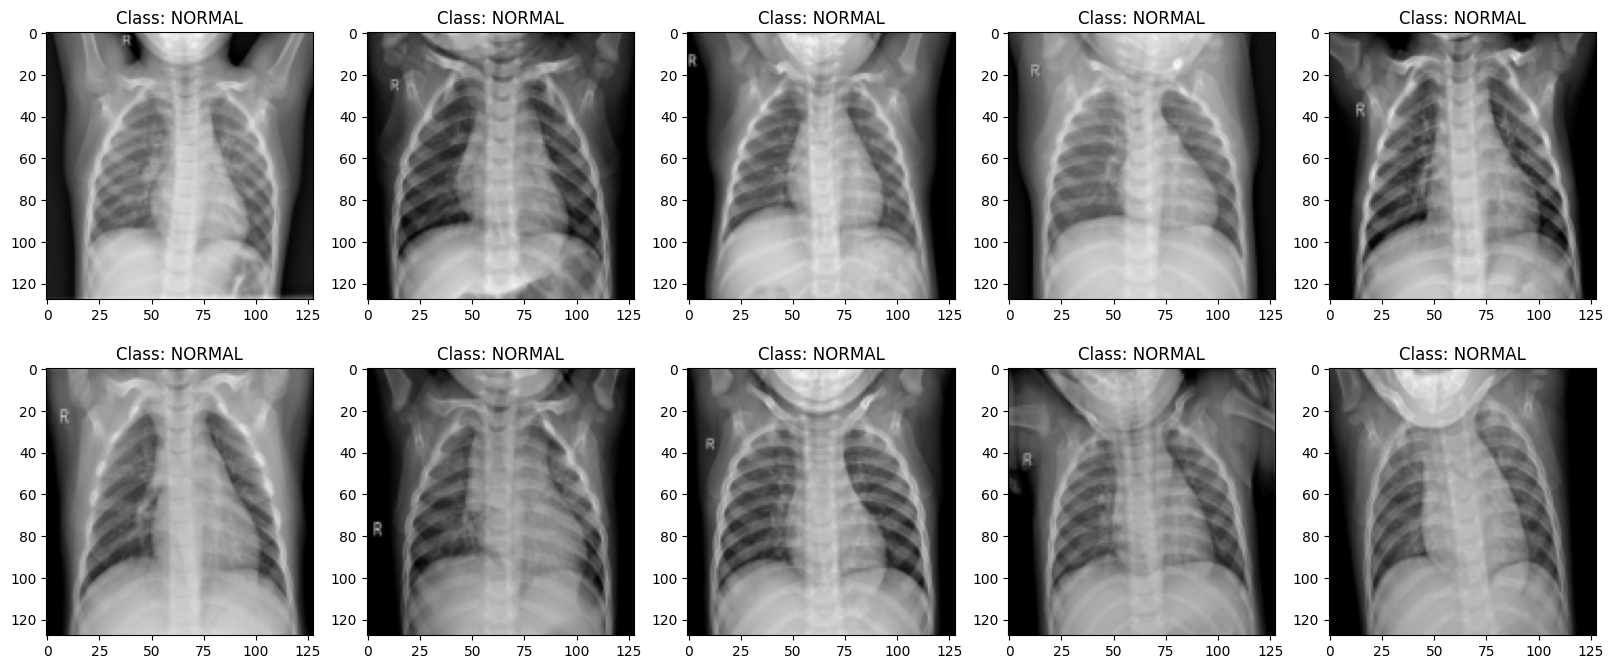

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """ 
        Given a tensor in input this function returns the corresponding image
        This function is not necessary if in the transformations we do not apply normalization
    """
    img = tensor.numpy().transpose((1, 2, 0)) # change the order of variables in order to get (width, heigth, channels)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    return img

# access the first ten images of the train dataset and print it
fig, axis = plt.subplots(2, 5, figsize=(20, 8))
axis = axis.flatten()  # make it an array instead of a matrix
for i in range(10):
    image_tensor, img_label = image_datasets["train"][i]
    
    img = denormalize(image_tensor)
    class_name = class_names[img_label] # if 0 will be 'NORMAL', IF 1 'PNEUMONIA'
    
    axis[i].imshow(img)
    axis[i].set_title(f"Class: {class_name}")
    
    

torch.Size([32, 3, 128, 128])
32


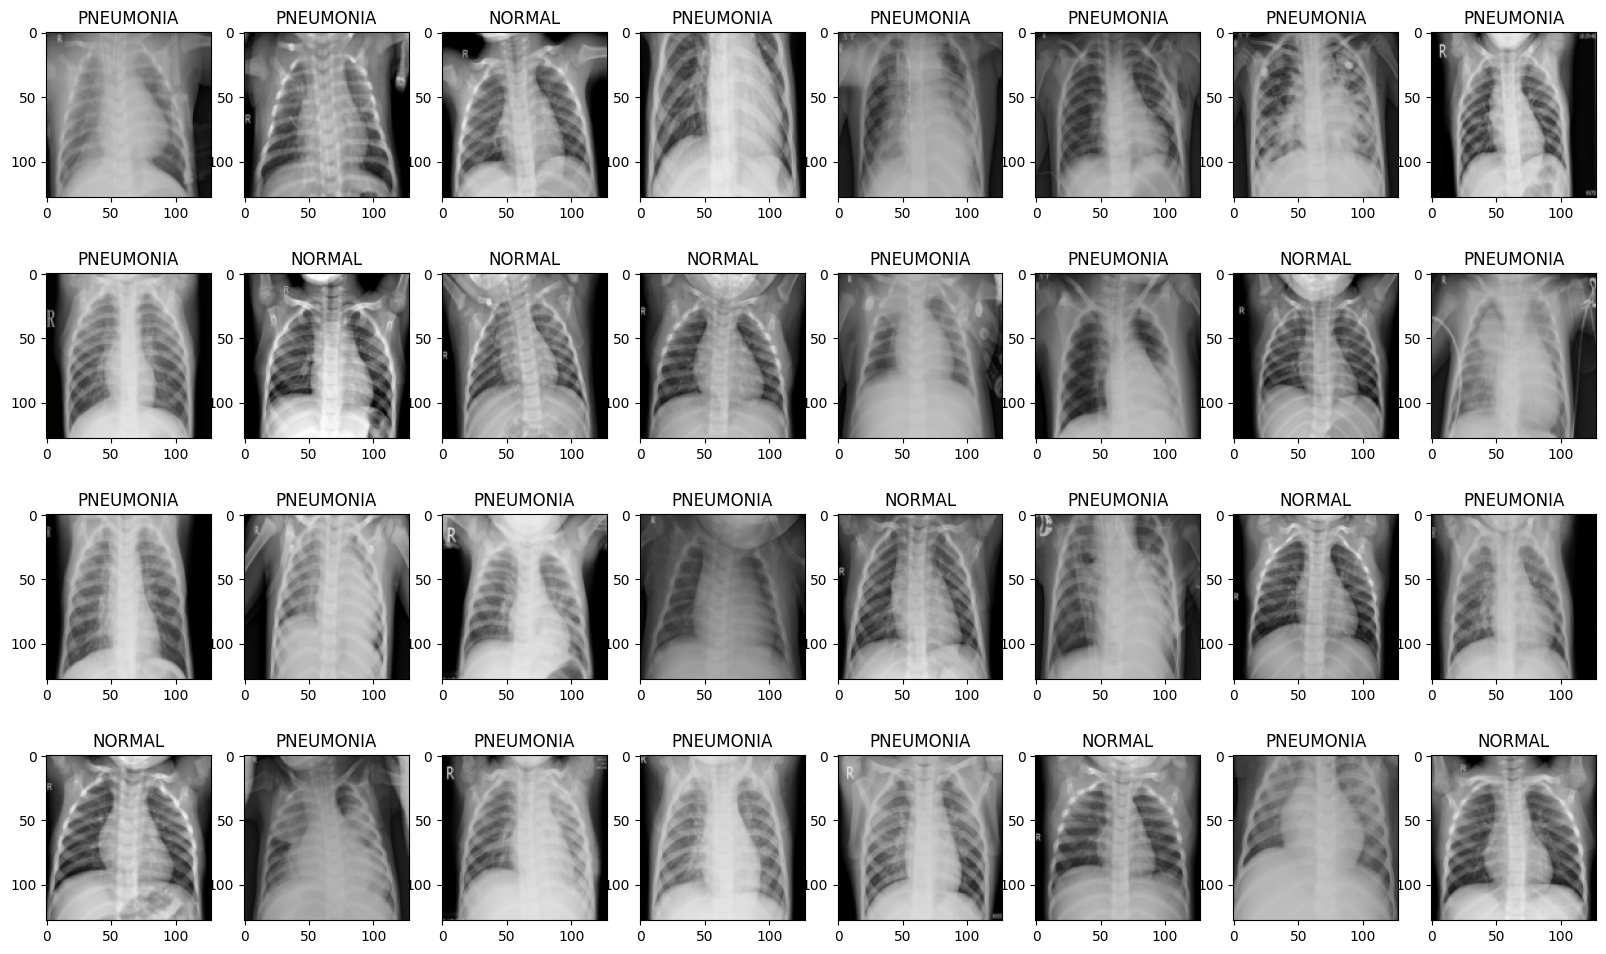

In [ ]:
BATCH_SIZE = 32
# initializing dataloaders for parallel calculus with GPU
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for x in datasets_names
}
# we access images in batches with an iterator
batch_images, batch_labels = next(iter(dataloaders["train"]))

print(batch_images.shape) # prints [batches, channels, width, heigth]
print(len(batch_images))

# another plot of the images, this time shuffled (lo sto facendo solo per prenderci la mano con i plot)
fig, axs = plt.subplots(4, 8, figsize=(20,12))
axs = axs.flatten()
for i in range(BATCH_SIZE):
    img = denormalize(batch_images[i])
    label_name = class_names[batch_labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(f"{label_name}")
    axs[i].axis("off")
    